In [1]:
#Instalacion tensorflow
# !pip install --upgrade tensorflow
import tensorflow
tensorflow.__version__

'2.18.0'

In [1]:
from os.path import join
from glob import glob
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt  # type: ignore
import PIL 
import random
from tensorflow.keras.callbacks import ReduceLROnPlateau # type: ignore

import cv2 as cv

from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, confusion_matrix, precision_score,recall_score, f1_score # type: ignore
import seaborn as sns # type: ignore

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.18.0


In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE 
BATCH_SIZE = 32 * strategy.num_replicas_in_sync 
IMAGE_SIZE = [176, 208] 
EPOCHS = 40 

In [3]:
data_folder = "./Alzheimer_MRI_4_classes_dataset"

df_NonDemented_imgs = pd.DataFrame({
    "X": sorted(glob(join(data_folder, "NonDemented", "*"))),
    "y": 0,
    "class": "NonDementia"
})
shuffled_non = df_NonDemented_imgs.sample(frac=1)
testsize_non = int(0.2 * len(shuffled_non))

non_test = shuffled_non[:testsize_non]

non_trainval = shuffled_non[testsize_non:]
trainsize_non = int(0.8 * len(non_trainval))

shuffled_non_train = non_trainval[:trainsize_non]

shuffled_non_val = non_trainval[trainsize_non:]


df_VeryMildDemented_imgs = pd.DataFrame({
    "X": sorted(glob(join(data_folder, "VeryMildDemented", "*"))),
    "y": 1,
    "class": "VeryMildDementia"
})
shuffled_verymild = df_VeryMildDemented_imgs.sample(frac=1)
testsize_verymild = int(0.2 * len(shuffled_verymild))

verymild_test = shuffled_verymild[:testsize_verymild]

verymild_trainval = shuffled_verymild[testsize_verymild:]
trainsize_verymild = int(0.8 * len(verymild_trainval))

shuffled_verymild_train = verymild_trainval[:trainsize_verymild]

shuffled_verymild_val = verymild_trainval[trainsize_verymild:]


df_MildDemented_imgs = pd.DataFrame({
    "X": sorted(glob(join(data_folder, "MildDemented", "*"))),
    "y": 2,
    "class": "MildDementia"
})
shuffled_mild = df_MildDemented_imgs.sample(frac=1)
testsize_mild = int(0.2 * len(shuffled_mild))

mild_test = shuffled_mild[:testsize_mild]

mild_trainval = shuffled_mild[testsize_mild:]
trainsize_mild = int(0.8 * len(mild_trainval))

shuffled_mild_train = mild_trainval[:trainsize_mild]

shuffled_mild_val = mild_trainval[trainsize_mild:]

df_ModerateDemented_imgs = pd.DataFrame({
    "X": sorted(glob(join(data_folder, "ModerateDemented", "*"))),
    "y": 3,
    "class": "ModerateDementia"
})
shuffled_moderate = df_ModerateDemented_imgs.sample(frac=1)
testsize_moderate = int(0.2 * len(shuffled_moderate))

moderate_test = shuffled_moderate[:testsize_moderate]

moderate_trainval = shuffled_moderate[testsize_moderate:]
trainsize_moderate = int(0.8 * len(moderate_trainval))

shuffled_moderate_train = moderate_trainval[:trainsize_moderate]

shuffled_moderate_val = moderate_trainval[trainsize_moderate:]

print("TOTAL:")
print("# of images with NonDemented Alzheimer =", len(shuffled_non))
print("# of images with VeryMildDemented Alzheimer =", len(shuffled_verymild))
print("# of images with MildDemented Alzheimer =", len(shuffled_mild))
print("# of images with ModerateDemented Alzheimer =", len(shuffled_moderate))
print("------------")
print("\nTest:")
print("# of images with NonDemented Alzheimer =", len(non_test))
print("# of images with VeryMildDemented Alzheimer =", len(verymild_test))
print("# of images with MildDemented Alzheimer =", len(mild_test))
print("# of images with ModerateDemented Alzheimer =", len(moderate_test))
print("------------")
print("\nTraining:")
print("# of images with NonDemented Alzheimer =", len(shuffled_non_train))
print("# of images with VeryMildDemented Alzheimer =", len(shuffled_verymild_train))
print("# of images with MildDemented Alzheimer =", len(shuffled_mild_train))
print("# of images with ModerateDemented Alzheimer =", len(shuffled_moderate_train))
print("------------")
print("\nValidation:")
print("# of images with NonDemented Alzheimer =", len(shuffled_non_val))
print("# of images with VeryMildDemented Alzheimer =", len(shuffled_verymild_val))
print("# of images with MildDemented Alzheimer =", len(shuffled_mild_val))
print("# of images with ModerateDemented Alzheimer =", len(shuffled_moderate_val))

TOTAL:
# of images with NonDemented Alzheimer = 3200
# of images with VeryMildDemented Alzheimer = 2240
# of images with MildDemented Alzheimer = 896
# of images with ModerateDemented Alzheimer = 64
------------

Test:
# of images with NonDemented Alzheimer = 640
# of images with VeryMildDemented Alzheimer = 448
# of images with MildDemented Alzheimer = 179
# of images with ModerateDemented Alzheimer = 12
------------

Training:
# of images with NonDemented Alzheimer = 2048
# of images with VeryMildDemented Alzheimer = 1433
# of images with MildDemented Alzheimer = 573
# of images with ModerateDemented Alzheimer = 41
------------

Validation:
# of images with NonDemented Alzheimer = 512
# of images with VeryMildDemented Alzheimer = 359
# of images with MildDemented Alzheimer = 144
# of images with ModerateDemented Alzheimer = 11


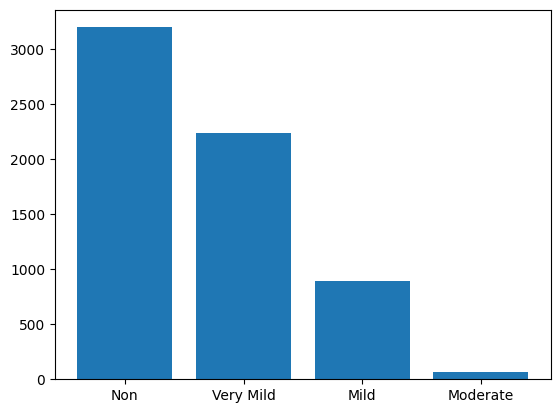

In [11]:

heights = [len(shuffled_non), len(shuffled_verymild), len(shuffled_mild), len(shuffled_moderate)]

fig, ax = plt.subplots()
height = heights
bars = ('Non', 'Very Mild', 'Mild', 'Moderate')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.show()

In [4]:
def load_image(fname):    
    img = cv.imread(fname)
    
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    resize = (IMAGE_SIZE[0], IMAGE_SIZE[1])
    img = cv.resize(img, resize)
    return img

def hot_array(class_number):
    ha = [0,0,0,0]
    ha[class_number] = 1
    return ha

In [5]:
train_concat = pd.concat([shuffled_mild_train, shuffled_moderate_train, shuffled_non_train, shuffled_verymild_train])

train_concat = train_concat.sample(frac=1)

train_concat["X"] = train_concat["X"].apply(load_image)

y_train_lab = train_concat["y"]
y_train_lab = np.array(y_train_lab) 

train_concat["y"] = train_concat["y"].apply(hot_array)

xtrain = np.stack(train_concat["X"])
ytrain = np.stack(train_concat["y"])


val_concat = pd.concat([shuffled_mild_val, shuffled_moderate_val, shuffled_non_val, shuffled_verymild_val])
val_concat = val_concat.sample(frac=1)
val_concat["X"] = val_concat["X"].apply(load_image)
val_concat["y"] = val_concat["y"].apply(hot_array)
xval = np.stack(val_concat["X"])
yval = np.stack(val_concat["y"])

Text(0, 0.5, 'Moderate Dementia')

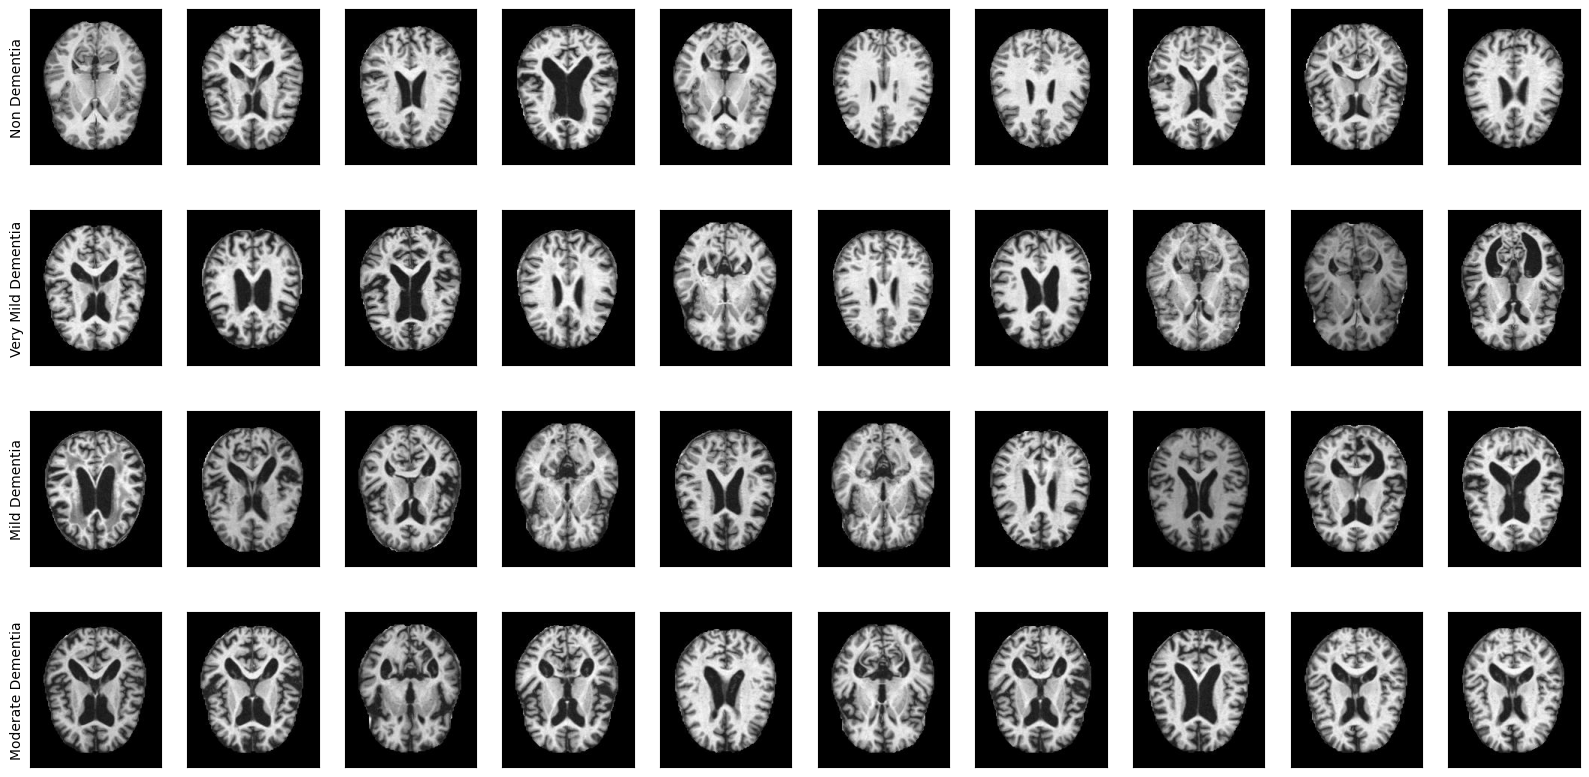

In [14]:
ncols = 10

fig, axs = plt.subplots(nrows=4, ncols=ncols, figsize=(20, 10))

for fname,ax in zip(shuffled_non.loc[:ncols, "X"], axs[0,:]):
    im = load_image(fname)
#     print(ax)
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

for fname,ax in zip(shuffled_verymild.loc[:ncols, "X"], axs[1,:]):
    im = load_image(fname)
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    
for fname,ax in zip(shuffled_mild.loc[:ncols, "X"], axs[2,:]):
    im = load_image(fname)
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

for fname,ax in zip(shuffled_moderate.loc[:ncols, "X"], axs[3,:]):
    im = load_image(fname)
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

axs[0,0].set_ylabel("Non Dementia")
axs[1,0].set_ylabel("Very Mild Dementia")
axs[2,0].set_ylabel("Mild Dementia")
axs[3,0].set_ylabel("Moderate Dementia")

In [6]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(2,2))
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
#         tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.3),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.5),
        dense_block(128, 0.3),
        
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    
#     METRICS = [tf.keras.metrics.AUC(name='auc')]
    
    model.compile(
        # Escogiendo el optimizador ADAM con learning rate de 0.001
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
    
    return model

In [7]:
with strategy.scope():
    model = build_model()
    model.summary()
# METRICS = [tf.keras.metrics.AUC(name='auc')]

# model.compile(
#     # Escogiendo el optimizador ADAM con learning rate de 0.001
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),

#     loss=tf.losses.CategoricalCrossentropy(),
#     metrics=['accuracy']
# )


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 176, 208, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 176, 208, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 88, 104, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 44, 52, 32)     │        14,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 22, 26, 64)     │        55,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 11, 13, 128)    │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 5, 6, 256)      │       886,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 512)            │     3,934,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 128)            │        66,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,182,100 (19.77 MB)

 Trainable params: 5,179,860 (19.76 MB)

 Non-trainable params: 2,240 (8.75 KB)

In [8]:
from livelossplot.tf_keras import PlotLossesCallback # type: ignore

In [9]:
path_model = "modl.weights.h5"
tf.keras.backend.clear_session() 

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint( path_model, 
                                                    save_best_only=True,
                                                    save_weights_only = True,
                                                    monitor="accuracy",
                                                    verbose=1)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, mode="auto",
                              patience=2, min_lr=0.00001)
class_weights = { 0: 1,
                  1: 1.5,
                  2: 3,
                  3: 20
}

history = model.fit(xtrain, ytrain, 
                    batch_size=BATCH_SIZE, 
                    epochs=40, 
                    callbacks=[PlotLossesCallback(),checkpoint_cb, reduce_lr,early_stopping_cb], 
                    validation_data=(xval, yval),
                    class_weight = class_weights)


Epoch 1/40
 60/128 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - accuracy: 0.2769 - loss: 3.4299

KeyboardInterrupt: 

In [21]:
loss, accuracy = model.evaluate(xtest,ytest)
print(loss)
print(accuracy)

40/40 [==============================] - 0s 9ms/step - loss: 0.1962 - accuracy: 0.9335
0.19616110622882843
0.9335418343544006


Text(0, 0.5, 'lr')

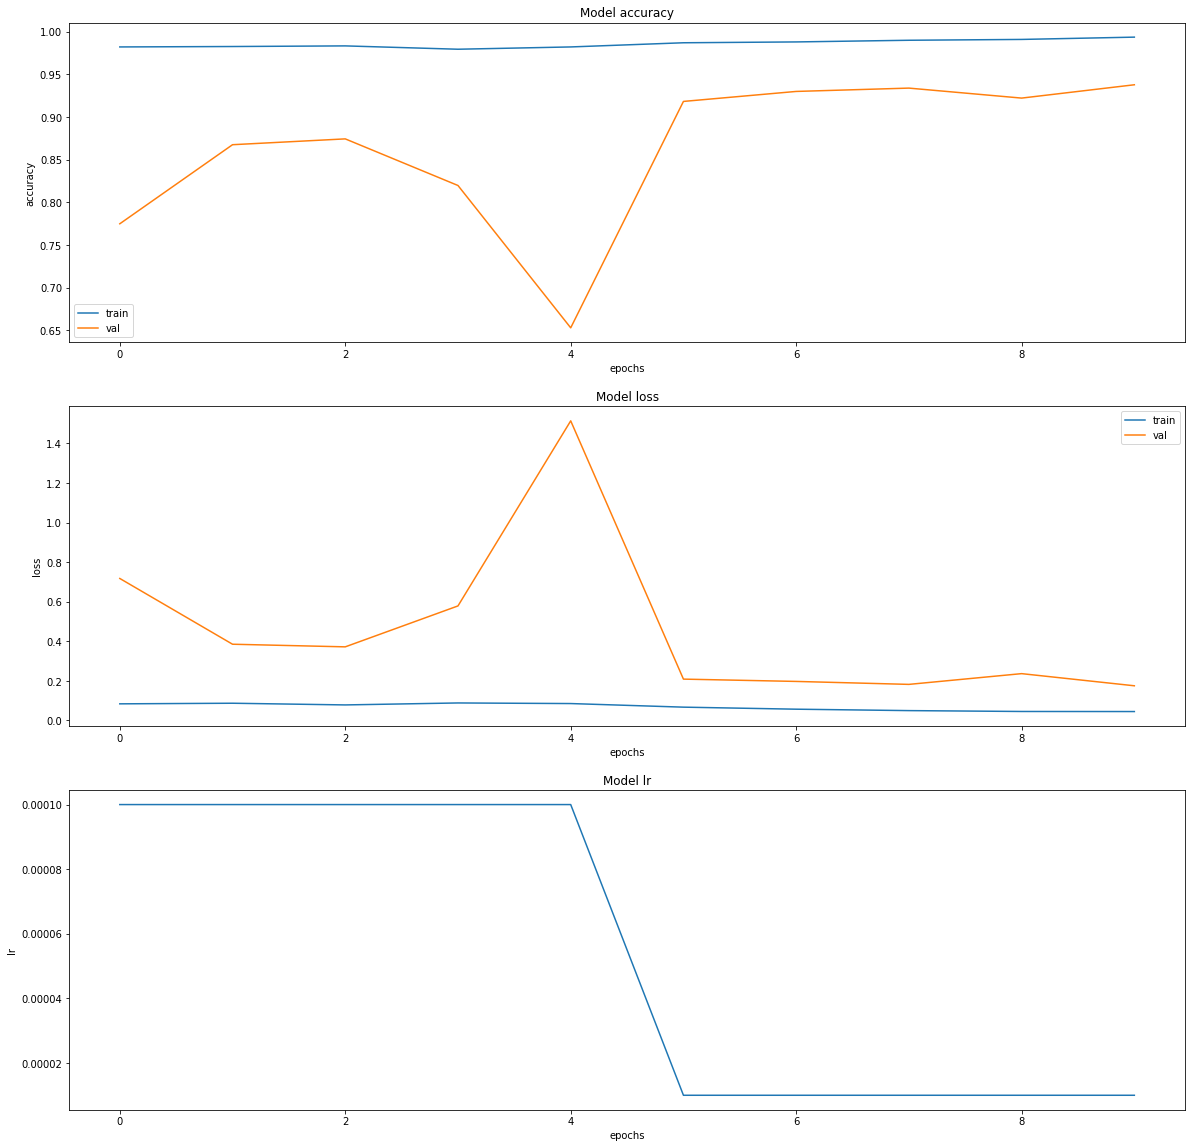

In [22]:
fig, ax = plt.subplots(3, 1, figsize=(20, 20))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

ax[2].plot(history.history['lr'])
ax[2].set_title('Model lr')
ax[2].set_xlabel('epochs')
ax[2].set_ylabel('lr')

In [15]:
## Set de prueba
test_concat = pd.concat([mild_test, moderate_test, non_test, verymild_test])
test_concat = test_concat.sample(frac=1)
test_concat["X"] = test_concat["X"].apply(load_image)
test_concat["y"] = test_concat["y"].apply(hot_array)
xtest = np.stack(test_concat["X"])
ytest = np.stack(test_concat["y"])

In [ ]:
xtest.shape

In [23]:
# # Evaluación
loss, accuracy = model.evaluate(xtest,ytest)
print(loss)
print(accuracy)
# # print(acc)


40/40 [==============================] - 0s 9ms/step - loss: 0.1962 - accuracy: 0.9335
0.19616110622882843
0.9335418343544006


In [24]:

def print_metrics(model, X, y, cm_labels="auto"):
    
    y_pred = model.predict(X)
    y_pred = np.squeeze(y_pred)
    y_pred = np.argmax(y_pred,1).astype(int)

    metrics = {
        "Accuracy"    : accuracy_score(y, y_pred),
        "Bal Accuracy": balanced_accuracy_score(y, y_pred),
        "Precision"   : precision_score(y, y_pred, average="macro"),
        "Recall"      : recall_score(y, y_pred, average="macro"),
        "f1"          : f1_score(y, y_pred, average="macro")
    }
    # Agrega AUC si el clasificador puede predecir probabilidades
#     try:
# #         y_pred_proba = model.predict_proba(X)
#         metrics["AUC"] = roc_auc_score(y, y_pred, multi_class="ovr", average="macro")
#     except:
#         metrics["AUC"] = np.nan
    
    for k,v in metrics.items():
        print("{:12s} = {}".format(k,v))  
    print("\n")
    
    # Matriz de confusión
    cm = confusion_matrix(y, y_pred, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    sns.heatmap(cm, ax=ax, square=True, vmin=0, vmax=1, annot=True, 
                linewidths=.05, fmt=".2f", cbar_kws={"shrink":.8}, 
                xticklabels=cm_labels, yticklabels=cm_labels)
    plt.xticks([0.5, 1.5, 2.5, 3.5], ['Non', 'Very Mild', 'Mild', 'Moderate'])
    plt.yticks([0.5, 1.5, 2.5, 3.5], ['Non', 'Very Mild', 'Mild', 'Moderate'])
    ax.set_ylabel("True")
    ax.set_xlabel("Predicted")

    metrics["cm"] = cm

    return metrics

Accuracy     = 0.9335418295543393
Bal Accuracy = 0.9403163657222665
Precision    = 0.9491462831364095
Recall       = 0.9403163657222665
f1           = 0.9445474603297399




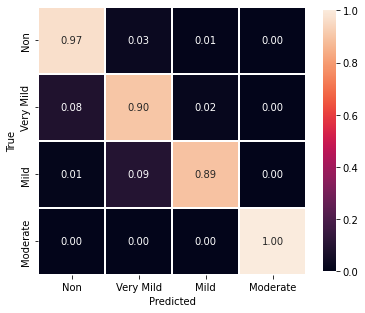

In [25]:
import warnings
warnings.filterwarnings('always')

y_test = ytest.argmax(axis=1)
met = print_metrics(model, xtest, y_test)

Accuracy     = 0.9335418295543393
Bal Accuracy = 0.9403163657222665
Precision    = 0.9491462831364095
Recall       = 0.9403163657222665
f1           = 0.9445474603297399




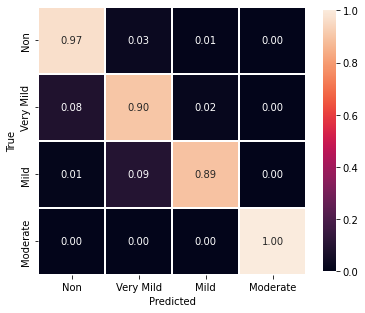

In [26]:
import warnings
warnings.filterwarnings('always')

y_test = ytest.argmax(axis=1)
met = print_metrics(model, xtest, y_test)

In [41]:
# model.save("mri_model.h5")
model_json = model.to_json()
with open("model_mri.json",'w') as json_file:
    json_file.write(model_json)
model.save("model_mri.h5")


In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score , classification_report


print(classification_report(y_test, y_pred))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, y_pred)*100))


              precision    recall  f1-score   support

           0       0.94      0.97      0.95       640
           1       0.92      0.90      0.91       448
           2       0.94      0.89      0.91       179
           3       1.00      1.00      1.00        12

    accuracy                           0.93      1279
   macro avg       0.95      0.94      0.94      1279
weighted avg       0.93      0.93      0.93      1279

Accuracy of the Model: 93.4%


In [29]:
y_pred = model.predict(xtest)
y_pred = np.squeeze(y_pred)
y_pred = np.argmax(y_pred,1).astype(int)

# labels = (y_test.class_indices)
# labels = dict((v,k) for k,v in labels.items())
pred2 = ['Non', 'Very Mild', 'Mild', 'Moderate']

In [42]:
from keras.models import model_from_json

json_file = open("/kaggle/working/model_mri.json", "r")
model_json = json_file.read()
json_file.close()
model22 = model_from_json(model_json)
model22.load_weights("/kaggle/working/model_mri.h5")

In [43]:
# # met = print_metrics(model22, xtest, y_test)
img = load_image('/kaggle/input/alzheimer-mri-4-classes-dataset/Alzheimer_MRI_4_classes_dataset/MildDemented/1 (10).jpg')
print(img.shape)
img.resize(1,208,176,3)
print(img.shape)
pr = model22.predict(img)
pr = np.squeeze(pr)
pr = np.argmax(pr)
print(pred2[pr])

(208, 176, 3)
(1, 208, 176, 3)
Mild
